In [132]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scipy.io as sio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

%matplotlib notebook

In [53]:
# function that bipolarizes any 2D numpy array
def bipolarize(hv):
    bihv = hv
    bihv[bihv < 0] = -1
    bihv[bihv > 0] = 1
    zeroLocs = np.argwhere(bihv == 0)
    for idx in zeroLocs:
        if len(idx) > 1:
            bihv[idx[0],idx[1]] = random.choice((-1,1))
        else:
            bihv[idx] = random.choice((-1,1))
            
    return bihv

In [54]:
# function that calculates cosine similarities
def cosine_similarity(a,b):
    return (a.T @ b)/(np.linalg.norm(a,axis=0).T * np.linalg.norm(b,axis=0))

# matlab implementation: sim = (im'*am)./(vecnorm(im)'*vecnorm(am));

In [55]:
# select subject and experiments
subject = 2
exp = 1

# load data
emgHD = sio.loadmat('/global/scratch/zfhusted/offline_experiments/S' + str(subject) + 'E' + str(exp))['emgHD']

# get metadata
numGest, numTrials = emgHD.shape

In [56]:
# load specific trial
g = 2 # gesture index
t = 1 # trial index

trial = emgHD[g][t]
rawData = trial[0]
label = trial[1][0,0]
features = trial[2]
ngrams = trial[3]

In [120]:
emgHD.shape

(13, 5)

<IPython.core.display.Javascript object>


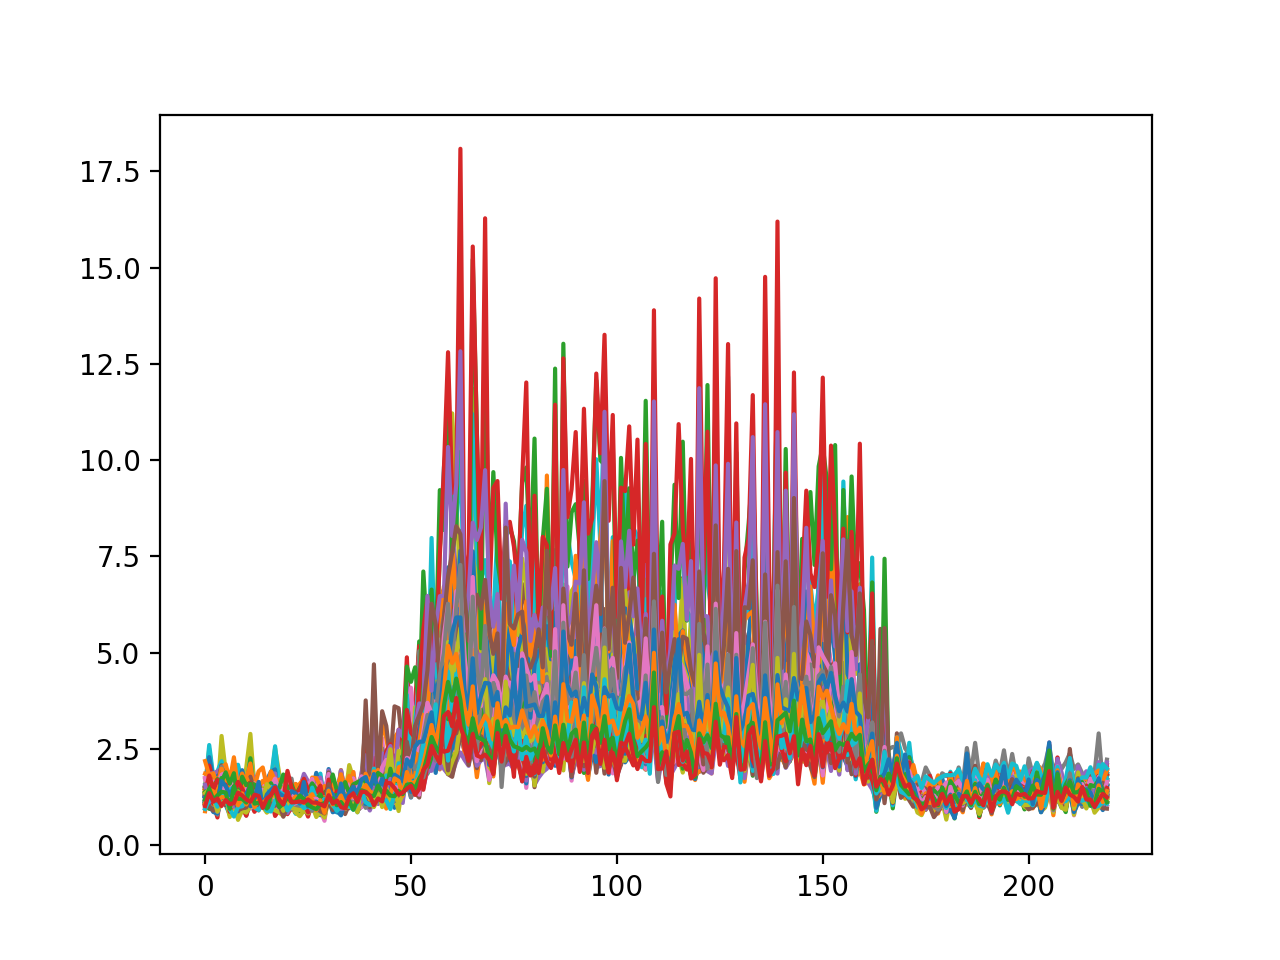

In [57]:
# gather and plot features
plt.plot(features)
plt.show()

In [58]:
# calculate gesture centroid from hold period
centroid = bipolarize(np.sum(ngrams[:,70:150],axis=1))

<IPython.core.display.Javascript object>


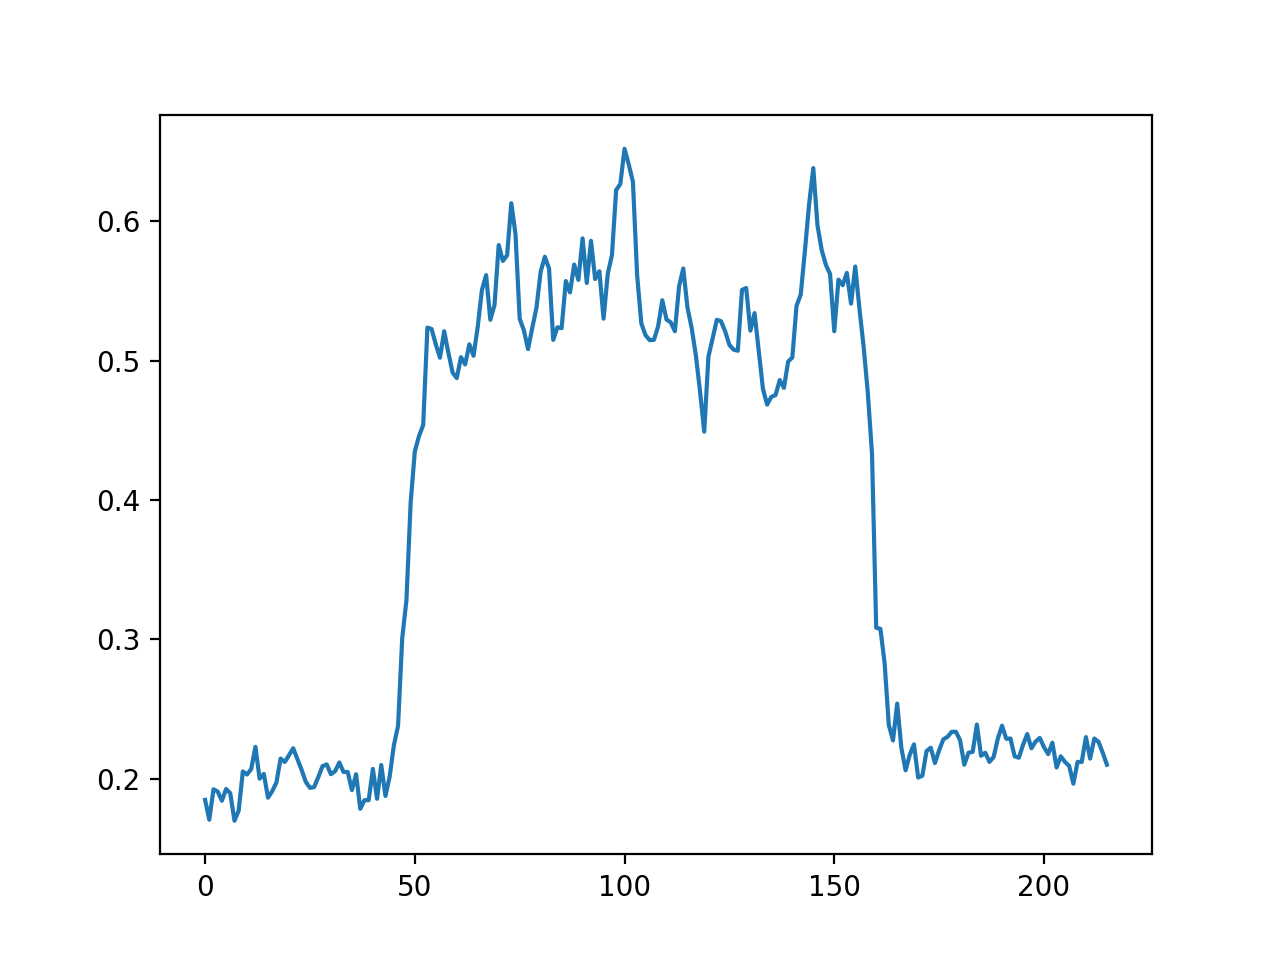

In [59]:
# compare ngrams with gesture centroid
sims = cosine_similarity(ngrams,centroid)
plt.plot(sims)
plt.show()

## Checking all trials of one gesture against centroid of another gesture

In [138]:
centroids = {}
for g in range(emgHD.shape[0]):
    t = np.random.randint(1, high=len(emgHD[g])-1)
    trial = emgHD[g][t]
    ngrams = trial[3]
    centroids[g] = bipolarize(np.sum(ngrams[:,70:150],axis=1))

In [139]:
gest_sims = {}

for g in range(emgHD.shape[0]):
    gest_sims[g] = {}
    for t in range(len(emgHD[g])):
        trial = emgHD[g][t]
        rawData = trial[0]
        label = trial[1][0,0]
        features = trial[2]
        ngrams = trial[3]
        
        for c in range(emgHD.shape[0]):
            sims = cosine_similarity(ngrams,centroids[c])
            if c not in gest_sims[g].keys():
                gest_sims[g][c] = []
            gest_sims[g][c] += [sims]

In [130]:
gest_sims.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

<IPython.core.display.Javascript object>


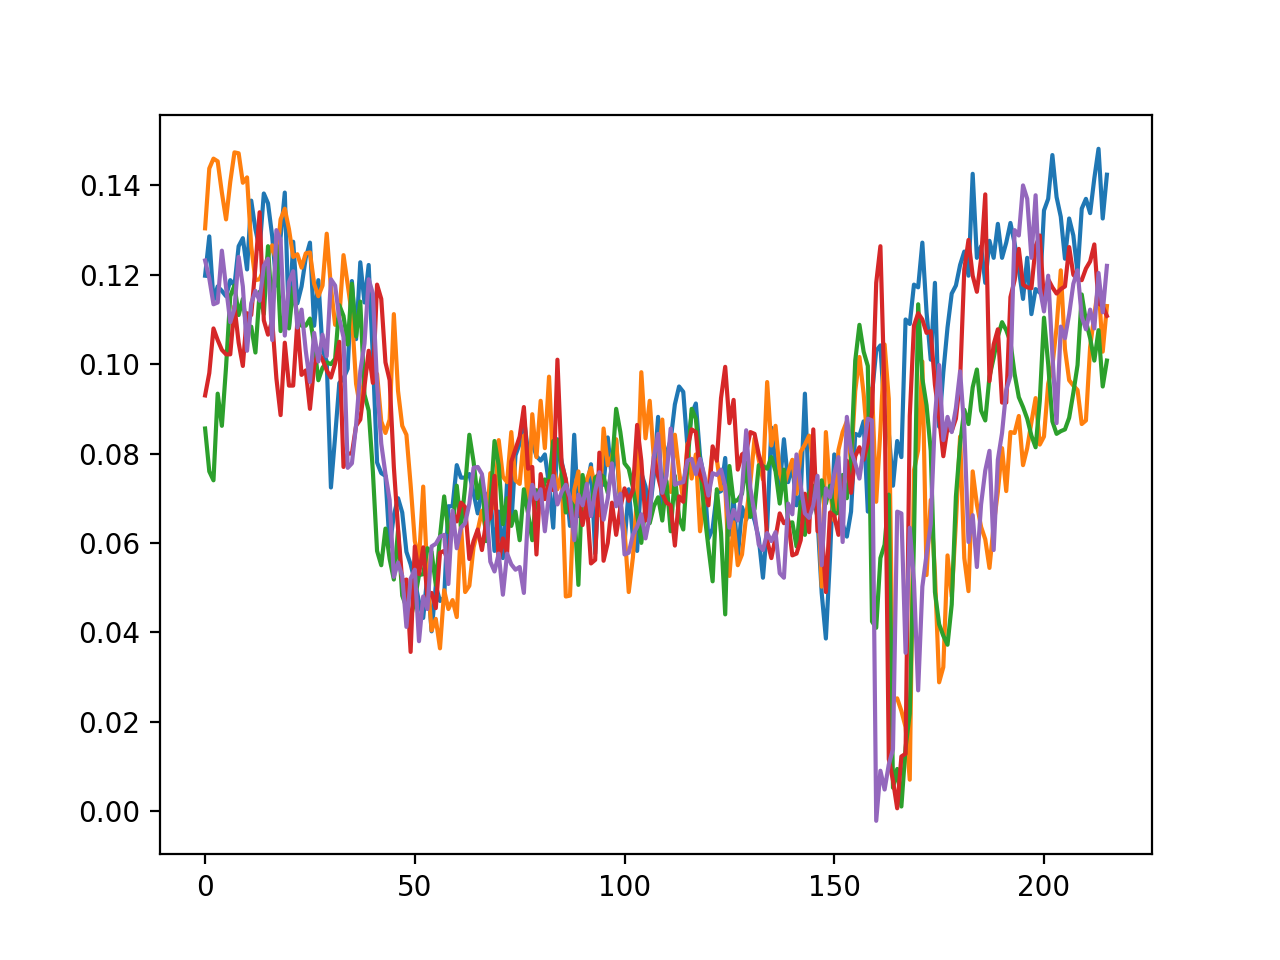

In [131]:
# plots similarity at gest_sims[g][c], gesture g with centroid of gesture c for all trials
for sim in gest_sims[5][2]:
    plt.plot(sim)
plt.show()

## Checking all of the centroids against a trial from a gesture

In [140]:
centroids = {}
for g in range(emgHD.shape[0]):
    t = np.random.randint(1, high=len(emgHD[g])-1)
    trial = emgHD[g][t]
    ngrams = trial[3]
    centroids[g] = bipolarize(np.sum(ngrams[:,70:150],axis=1))

In [145]:
gest_sims_2 = {}

#loop through gestures
for g in range(emgHD.shape[0]):
    gest_sims_2[g] = {}
    for t in range(len(emgHD[g])):
        trial = emgHD[g][t]
        rawData = trial[0]
        label = trial[1][0,0]
        features = trial[2]
        ngrams = trial[3]
        
        for c in range(emgHD.shape[0]):
            sims = cosine_similarity(ngrams,centroids[c])
            if t not in gest_sims_2[g].keys():
                gest_sims_2[g][t] = []
            gest_sims_2[g][t] += [sims]

<IPython.core.display.Javascript object>


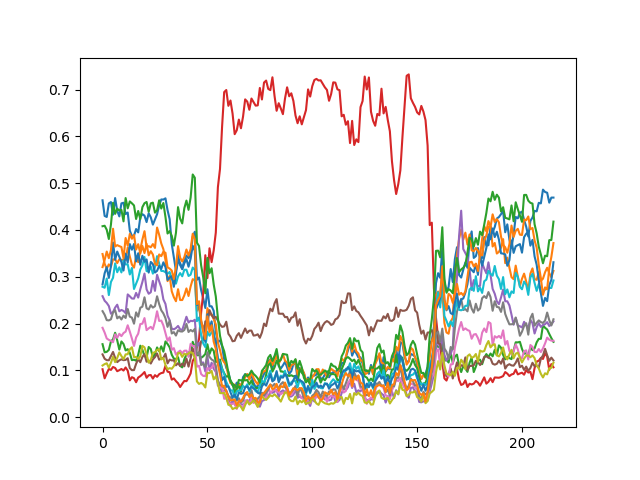

In [224]:
# plots similarity at gest_sims_2[g][t] with gesture g and trial t across all the centroids
for sim in gest_sims_2[3][2]:
    plt.plot(sim)
plt.show()

## Predictions

In [231]:
maxes = {}
for g in gest_sims_2.keys():
    maxes[g] = {}
    for t in range(len(gest_sims_2[g])):
        maxes[g][t] = np.argmax(gest_sims_2[g][t], axis=0)
    

In [227]:
gest_sims_2.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

<IPython.core.display.Javascript object>


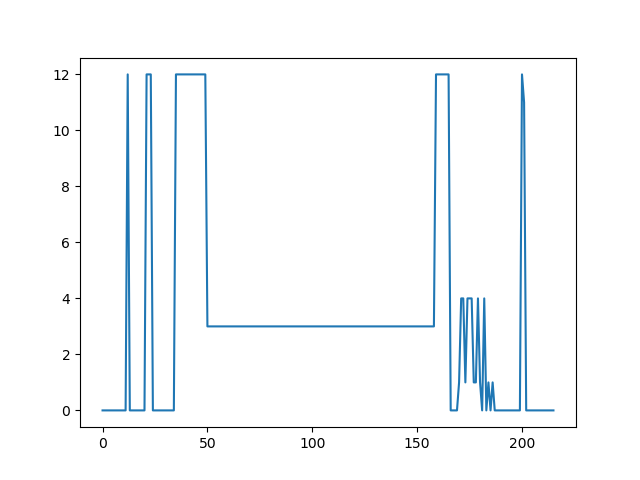

In [237]:
plt.plot(maxes[3][3])
plt.show()

## Errors

In [242]:
errors = {}
for g in maxes.keys():
    errors[g] = {}
    for t in range(len(gest_sims_2[g])):
        errors[g][t] = (maxes[g][t] != g)

<IPython.core.display.Javascript object>


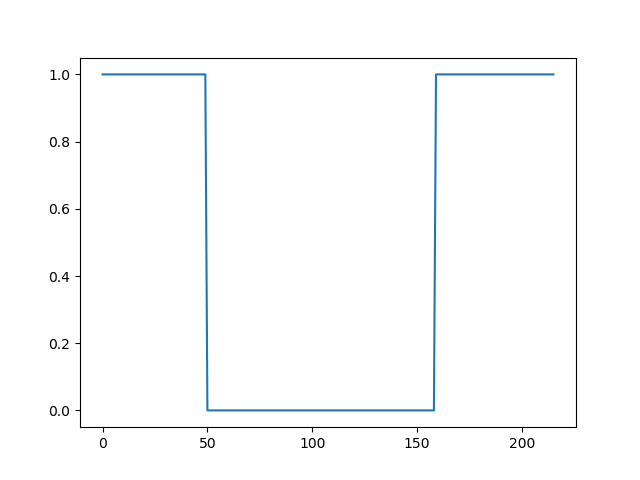

In [245]:
plt.plot(errors[3][3])
plt.show()

In [ ]:
#time aligning the error vector to the onset and offset --> using change point analysis
#take average over all gestures & trials
# elementwise comparison to ground truth array